In [72]:
## Imports
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
import json
import matplotlib.pyplot as plt
import glob
import os
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.externals import *
from dateutil.parser import parse
import datetime as dt

In [2]:
## Define paths
DATA_FOLDER = './data/'
DATA_PATH = DATA_FOLDER + 'train.tsv'

In [3]:
## Load raw data
cols = ["ID", "label", "statement", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]
    
df_raw = pd.read_table(DATA_PATH, header=None)
df_raw.columns = cols
df_raw.head()

,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [4]:
## Check types and shape
print(df_raw.dtypes)
print(df_raw.shape)

ID                    object
label                 object
statement             object
subject               object
speaker               object
job                   object
state                 object
party                 object
barely_true_cts      float64
false_cts            float64
half_true_cts        float64
mostly_true_cts      float64
pants_on_fire_cts    float64
context               object
dtype: object
(10240, 14)


In [5]:
## Help put data in useful form - split topics as list and separate into new rows for grouping
## Split subjects into lists
subject_split = df_raw.copy()
subject_split["subject"] = df_raw["subject"].apply(lambda x : str(x).lower().split(","))
subject_split.head()

,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,2635.json,false,Says the Annies List political group supports ...,[abortion],dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,[health-care],blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [6]:
## Create a dataframe of all subjects
subjects = subject_split.subject.apply(pd.Series)
new_cols = cols.copy()
new_cols.remove("subject")

## Now merge with original frame to create separate columns for each subject
## Then melt so that each entry exists under several subjects
subject_split = subjects.merge(subject_split, right_index = True, left_index = True) \
    .drop(["subject"], axis = 1) \
    .melt(id_vars = new_cols, value_name = "subject") \
    .drop("variable", axis = 1) \
    .dropna()

subject_split.head()

,ID,label,statement,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context,subject
0,2635.json,false,Says the Annies List political group supports ...,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,abortion
1,10540.json,half-true,When did the decline of coal start? It started...,scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,energy
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,foreign-policy
5,12465.json,true,The Chicago Bears have had more starting quart...,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,education
7,153.json,half-true,I'm the only person on this stage who has work...,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa.",ethics


In [7]:
breakdown = subject_split.groupby(["subject","label"]).agg({"ID" : "count"})
breakdown.head()

ID
subject           label          
10-news-tampa-bay barely-true   1
                  half-true     1
abc-news-week     barely-true   5
                  false        12
                  half-true    15

In [8]:
breakdown.index.levels[0]

Index(['10-news-tampa-bay', 'abc-news-week', 'abortion', 'afghanistan',
       'agriculture', 'alcohol', 'animals', 'bankruptcy', 'baseball',
       'bipartisanship',
       ...
       'unions', 'urban', 'veterans', 'voting-record', 'water', 'wealth',
       'weather', 'welfare', 'women', 'workers'],
      dtype='object', name='subject', length=139)

In [9]:
a = breakdown.reset_index()
a.head()

,subject,label,ID
0,10-news-tampa-bay,barely-true,1
1,10-news-tampa-bay,half-true,1
2,abc-news-week,barely-true,5
3,abc-news-week,false,12
4,abc-news-week,half-true,15


In [10]:
totals = a.groupby(a["subject"]).agg({"ID" : "sum"})
falses = a.where(a["label"]=="false").groupby(a["subject"]).agg({"ID" : "sum"})

In [11]:
subjects = totals.index
percent_falses = np.array(falses.values)/np.array(totals.values)


In [12]:
# pd.DataFrame(np.c_[np.array(subjects), percent_falses])
percent_falses = pd.DataFrame(np.array(falses.values)/np.array(totals.values))
percent_falses.index = subjects
percent_falses.columns = ["Percentage as Lies"]
percent_falses.head()

,Percentage as Lies
subject,
10-news-tampa-bay,0.000000
abc-news-week,0.200000
abortion,0.163121
afghanistan,0.235294
agriculture,0.162791


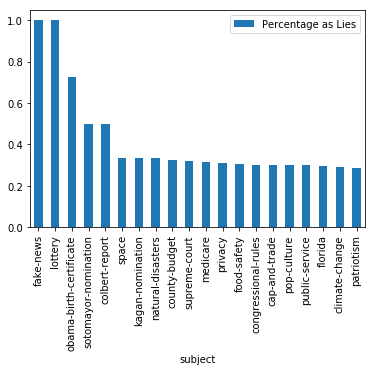

In [13]:
percent_falses.sort_values("Percentage as Lies", ascending=False, inplace=True)
percent_falses.head(20).plot(kind="bar")

In [14]:
#############################################################################################

In [15]:
# Cleaning state field
subject_split['state'] = subject_split['state'].apply(lambda x: "Washington" if x == "Washington, D.C." or x == "Washington, D.C. " or x == "Washington state" or x == "Washington DC" or x == "Washington D.C." else x)
subject_split['state'] = subject_split['state'].apply(lambda x: "Wisconsin" if x == "Wisconsin " else x)
subject_split['state'] = subject_split['state'].apply(lambda x: "Ohio" if x == "ohio" else x)
subject_split['state'] = subject_split['state'].apply(lambda x: "New York" if x == "New York " else x)
subject_split['state'] = subject_split['state'].apply(lambda x: "Illinois" if x == "Illinois " else x)
subject_split['state'] = subject_split['state'].apply(lambda x: "Georgia" if x == "Georgia " else x)
subject_split['state'] = subject_split['state'].apply(lambda x: "Florida" if x == "Florida " else x)
subject_split['state'] = subject_split['state'].apply(lambda x: "Colorado" if x == "Colorado " else x)
subject_split['state'] = subject_split['state'].apply(lambda x: "Massachusetts" if x == "Massachusetts " else x)
subject_split['state'] = subject_split['state'].apply(lambda x: "Pennsylvania" if x == "PA - Pennsylvania" else x)
subject_split['state'] = subject_split['state'].apply(lambda x: "Tennessee" if x == "Tennesse" else x)
subject_split['state'] = subject_split['state'].apply(lambda x: "Virginia" if x == "Virgiia" or x == "Virgina" or x == "Virginia " or x == "Virginia director, Coalition to Stop Gun Violence" else x)

In [16]:
# Cleaning context field
subject_split['context'] = subject_split['context'].apply(lambda x: "a speech" if x == "a speech." or x == "in a speech" else x)
subject_split['context'] = subject_split['context'].apply(lambda x: "a television interview" if x == "a TV interview" or x == "a TV interview." else x)
subject_split['context'] = subject_split['context'].apply(lambda x: "a debate" if x == "a debate." else x)
subject_split['context'] = subject_split['context'].apply(lambda x: "a radio interview" if x == "a radio interview." else x)
subject_split['context'] = subject_split['context'].apply(lambda x: "an interview" if x == "an interview." else x)
subject_split['context'] = subject_split['context'].apply(lambda x: "a television commercial" if x == "a TV commercial" else x)
subject_split['context'] = subject_split['context'].apply(lambda x: "a television ad" if x == "a TV ad." or x == "a TV ad" else x)
subject_split['context'] = subject_split['context'].apply(lambda x: "a press release" if x == "a press release." else x)
subject_split['context'] = subject_split['context'].apply(lambda x: "a news release" if x == "a news release." else x)

In [17]:
# Cleaning job field
subject_split['job'] = subject_split['job'].apply(lambda x: "Governor" if x == "governor" else x)
subject_split['job'] = subject_split['job'].apply(lambda x: "U.S. Senator" if x == "U.S. senator" else x)
subject_split['job'] = subject_split['job'].apply(lambda x: "U.S. Representative" if x == "U.S. representative" or x == "U.S. House of Representatives" else x)
subject_split['job'] = subject_split['job'].apply(lambda x: "State Representative" if x == "State representative" or x == "state representative" else x)
subject_split['job'] = subject_split['job'].apply(lambda x: "State Senator" if x == "State senator" else x)
subject_split['job'] = subject_split['job'].apply(lambda x: "State Senator" if x == "State senator" or x == "state senator" else x)
subject_split['job'] = subject_split['job'].apply(lambda x: "State Senator" if x == "State senator" or x == "state senator" else x)

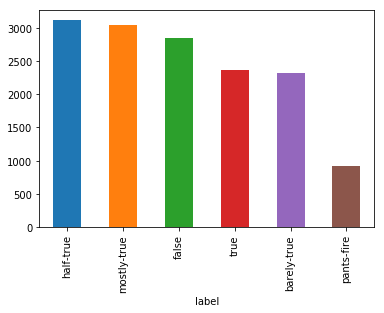

In [18]:
# Most present label
sorted_label_counts = subject_split.groupby('label').label.count().sort_values(ascending=False)
sorted_label_counts.plot(kind = "bar")

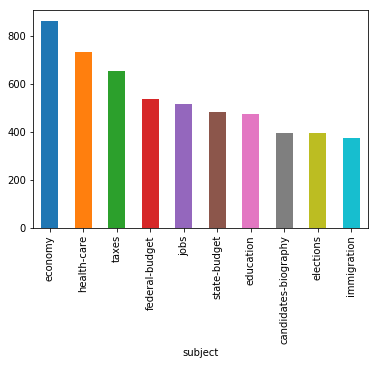

In [19]:
# Most present subjects
sorted_subjects_counts = subject_split.groupby('subject').subject.count().sort_values(ascending=False)
sorted_subjects_counts.head(10).plot(kind = "bar")

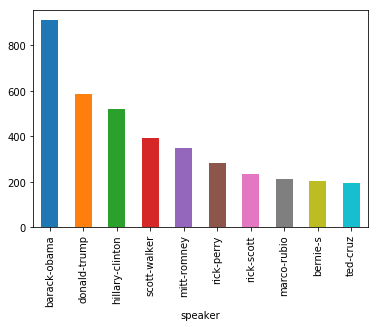

In [20]:
# Most present speakers
sorted_speakers_counts = subject_split.groupby('speaker').speaker.count().sort_values(ascending=False)
sorted_speakers_counts.head(10).plot(kind = "bar")

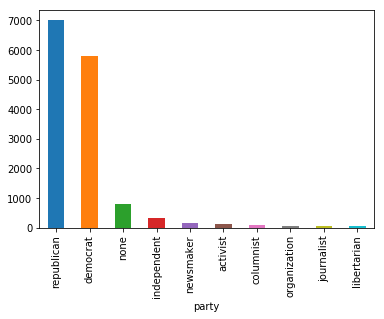

In [21]:
# Most present parties
sorted_parties_counts = subject_split.groupby('party').party.count().sort_values(ascending=False)
sorted_parties_counts.head(10).plot(kind = "bar")

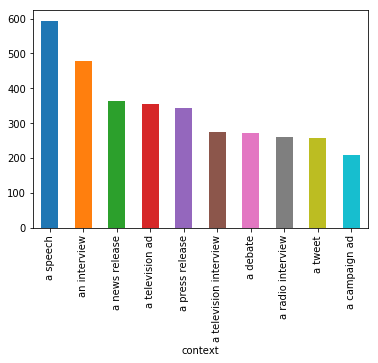

In [22]:
# Most present contexts
sorted_contexts_counts = subject_split.groupby('context').context.count().sort_values(ascending=False)
sorted_contexts_counts.head(10).plot(kind = "bar")

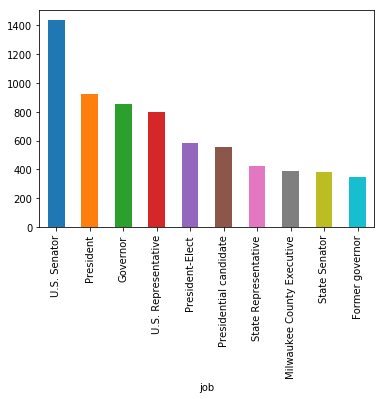

In [23]:
# Most present jobs
sorted_jobs_counts = subject_split.groupby('job').job.count().sort_values(ascending=False)
sorted_jobs_counts.head(10).plot(kind = "bar")

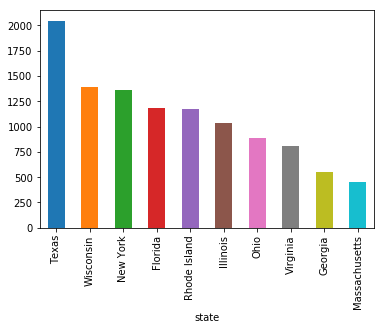

In [24]:
# Most present state
sorted_states_counts = subject_split.groupby('state').state.count().sort_values(ascending=False)
sorted_states_counts.head(10).plot(kind = "bar")

In [25]:
### Some distributions for the categories

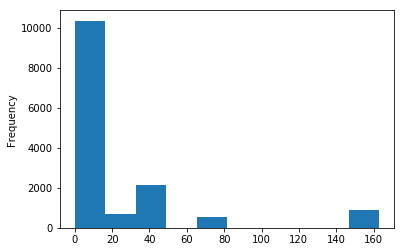

In [26]:
subject_split['mostly_true_cts'].plot(kind='hist')

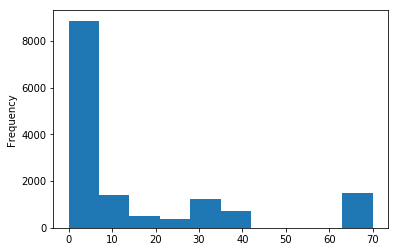

In [27]:
subject_split['barely_true_cts'].plot(kind='hist')

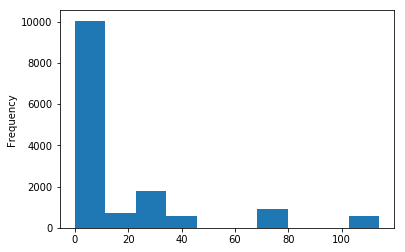

In [28]:
subject_split['false_cts'].plot(kind='hist')

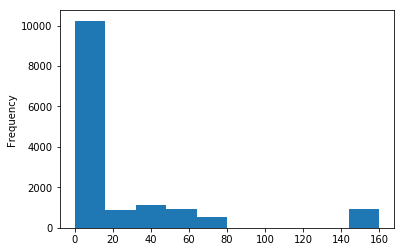

In [29]:
subject_split['half_true_cts'].plot(kind='hist')

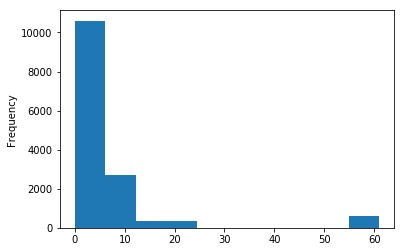

In [30]:
subject_split['pants_on_fire_cts'].plot(kind='hist')

In [31]:
# Descriptive statistics for pants_on_fire category
print("Mean: ", subject_split['pants_on_fire_cts'].mean())
print("Standard deviation: ", subject_split['pants_on_fire_cts'].std())
print("Median: ", subject_split['pants_on_fire_cts'].median())

Mean:  5.56925814399124
Standard deviation:  12.271864260864652
Median:  1.0


In [32]:
# Descriptive statistics for false category
print("Mean: ", subject_split['false_cts'].mean())
print("Standard deviation: ", subject_split['false_cts'].std())
print("Median: ", subject_split['false_cts'].median())

Mean:  16.35320284697509
Standard deviation:  27.469265458004596
Median:  3.0


In [33]:
subject_split[['false_cts', 'pants_on_fire_cts']].corr()

,false_cts,pants_on_fire_cts
false_cts,1.000000,0.863276
pants_on_fire_cts,0.863276,1.000000


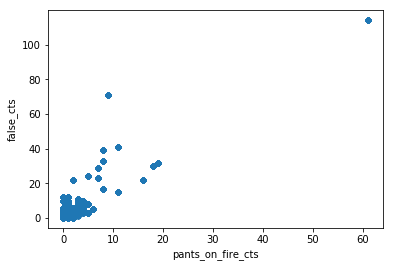

In [34]:
subject_split[['false_cts', 'pants_on_fire_cts']].plot(x='pants_on_fire_cts', y='false_cts', kind="scatter")

In [35]:
# Who tells more lies?

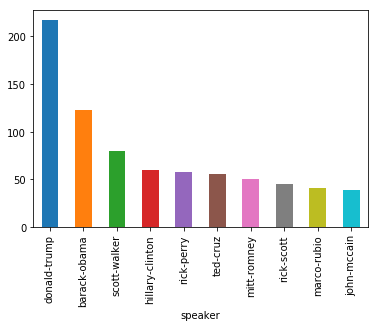

In [36]:
sorted_liers_counts = subject_split[subject_split.label == "false"].groupby('speaker').speaker.count().sort_values(ascending=False)
sorted_liers_counts.head(10).plot(kind = "bar")

In [37]:
### In which US state are lies more widespread?

In [38]:
# Computing percentage of lies

states_lies_count = subject_split[subject_split.label == "false"].groupby('state').state.count()
states_count = subject_split.groupby('state').state.count()
states_tot_false = pd.concat([states_count, states_lies_count], axis=1, sort=True).dropna()
states_tot_false.columns = ['count_tot', 'count_false']
states_tot_false.count_false = states_tot_false.count_false.astype('int64')
states_tot_false['perc_lies'] = (states_tot_false.count_false / states_tot_false.count_tot) * 100
states_tot_false.reset_index(inplace=True)
states_tot_false.columns = ['state', 'count_tot', 'count_false', 'perc_lies']
states_tot_false.head()

,state,count_tot,count_false,perc_lies
0,Alabama,13,6,46.153846
1,Alaska,27,10,37.037037
2,Arizona,212,44,20.754717
3,Arkansas,164,13,7.926829
4,California,270,56,20.740741


In [39]:
state_geo_path = r'us-states.json'
geo_json_data = json.load(open(state_geo_path))

us_map = folium.Map(location=[48, -102], zoom_start=3)
us_map.choropleth(geo_data=geo_json_data, data=states_tot_false,
             columns=['state', 'perc_lies'],
             key_on='feature.properties.name',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of lies (%)')
us_map

In [40]:
# Computing percentage of pants-fire

states_lies_count = subject_split[subject_split.label == "pants-fire"].groupby('state').state.count()
states_count = subject_split.groupby('state').state.count()
states_tot_false = pd.concat([states_count, states_lies_count], axis=1, sort=True).dropna()
states_tot_false.columns = ['count_tot', 'count_false']
states_tot_false.count_false = states_tot_false.count_false.astype('int64')
states_tot_false['perc_lies'] = (states_tot_false.count_false / states_tot_false.count_tot) * 100
states_tot_false.reset_index(inplace=True)
states_tot_false.columns = ['state', 'count_tot', 'count_false', 'perc_lies']
states_tot_false.head()

,state,count_tot,count_false,perc_lies
0,Alaska,27,1,3.703704
1,Arizona,212,6,2.830189
2,Arkansas,164,14,8.536585
3,California,270,19,7.037037
4,Delaware,115,8,6.956522


In [41]:
state_geo_path = r'us-states.json'
geo_json_data = json.load(open(state_geo_path))

us_map = folium.Map(location=[48, -102], zoom_start=3)
us_map.choropleth(geo_data=geo_json_data, data=states_tot_false,
             columns=['state', 'perc_lies'],
             key_on='feature.properties.name',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of lies (%)')
us_map

In [42]:
# Computing percentage of pants_of_fire historic counts

states_pof = subject_split[subject_split.pants_on_fire_cts > 0].groupby('state').pants_on_fire_cts.sum()
states_pof_df = pd.DataFrame(states_pof, ).reset_index()
states_pof_df.head()

,state,pants_on_fire_cts
0,Alaska,7.0
1,Arizona,1392.0
2,Arkansas,479.0
3,California,187.0
4,Delaware,420.0


In [43]:
us_map = folium.Map(location=[48, -102], zoom_start=3)
us_map.choropleth(geo_data=geo_json_data, data=states_pof_df,
             columns=['state', 'pants_on_fire_cts'],
             key_on='feature.properties.name',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Pof historic counts')
us_map

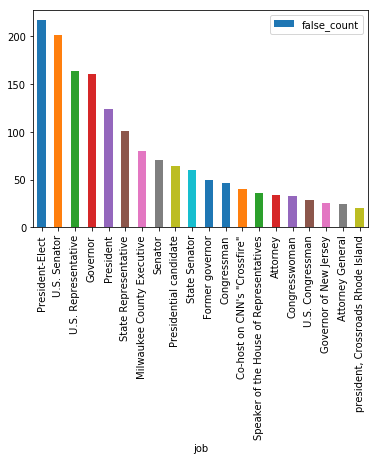

In [44]:
# Let's analyze the jobs with more lies
job_false = subject_split[subject_split.label == "false"].groupby("job").ID.count()
job_false_df = pd.DataFrame(job_false).reset_index()
job_false_df.columns = ['job', 'false_count']
job_false_df_max = job_false_df.sort_values(by='false_count' ,ascending=False).head(20)
job_false_df_max.plot(x = 'job', y='false_count', kind="bar")

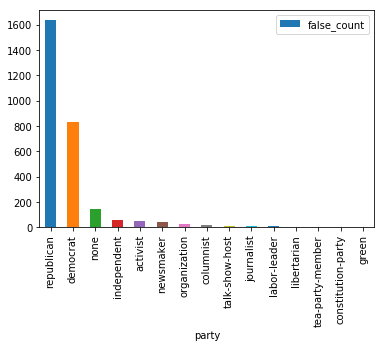

In [45]:
# Let's analyze the parties with more lies
party_false = subject_split[subject_split.label == "false"].groupby("party").ID.count()
party_false_df = pd.DataFrame(party_false).reset_index()
party_false_df.columns = ['party', 'false_count']
party_false_df_max = party_false_df.sort_values(by='false_count' ,ascending=False).head(20)
party_false_df_max.plot(x = 'party', y='false_count', kind="bar")

In [46]:
# Let's analyze both at the same time
party_job_false = subject_split[subject_split.label == "false"].groupby(["job", "party"]).ID.count()
party_job_false_df = pd.DataFrame(party_job_false).reset_index()
party_job_false_df.columns = ['job', 'party', 'false_count']
party_job_false_df_sorted = party_job_false_df.sort_values(by='false_count' ,ascending=False)
merge_party_job = party_job_false_df_sorted.merge(party_job_false_df_sorted, on='job')
merge_party_job = merge_party_job[(merge_party_job.party_x == 'republican') & (merge_party_job.party_y == 'democrat')]
merge_party_job = merge_party_job.sort_values(by='false_count_x', ascending=False)
data_matrix = merge_party_job.iloc[:4]
data_matrix

,job,party_x,false_count_x,party_y,false_count_y
2,Governor,republican,149,democrat,12
10,U.S. Senator,republican,110,democrat,64
19,U.S. Representative,republican,109,democrat,55
24,State Representative,republican,71,democrat,30


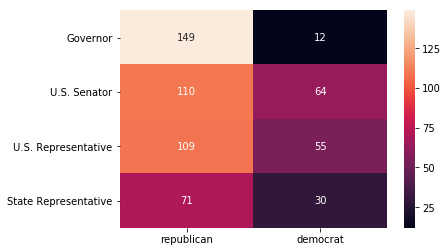

In [47]:
sns.heatmap(np.matrix(data_matrix[['false_count_x', 'false_count_y']]), annot=True, fmt="d", xticklabels=['republican', 'democrat'], yticklabels=data_matrix['job'])

In [48]:
### In which contexts people lie more?

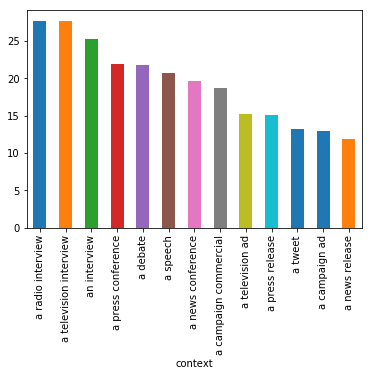

In [49]:
# Contexts where people tell more lies: false label
context_false_counts = subject_split[subject_split.label == "false"].groupby('context').context.count().sort_values(ascending=False).head(13)
context_total_counts = subject_split.groupby('context').context.count().sort_values(ascending=False).head(13)
context_perc_false = (context_false_counts / context_total_counts) * 100
context_perc_false.dropna().sort_values(ascending=False).plot(kind = "bar")

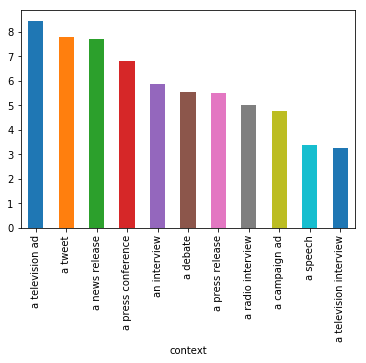

In [50]:
# Contexts where people tell more lies: pants-fire label
context_false_counts = subject_split[subject_split.label == "pants-fire"].groupby('context').context.count().sort_values(ascending=False).head(13)
context_total_counts = subject_split.groupby('context').context.count().sort_values(ascending=False).head(13)
context_perc_false = (context_false_counts / context_total_counts) * 100
context_perc_false.dropna().sort_values(ascending=False).plot(kind = "bar")

In [51]:
### Let's train a classifier to identify lies just based on features (not nlp)

In [74]:
def preprocess_data(data):
    # from Marshall
    subject_split = data.copy()
    subject_split["subject"] = df_raw["subject"].apply(lambda x : str(x).lower().split(","))
    subjects = subject_split.subject.apply(pd.Series)
    new_cols = cols.copy()
    new_cols.remove("subject")

    ## Now merge with original frame to create separate columns for each subject
    ## Then melt so that each entry exists under several subjects
    subject_split = subjects.merge(subject_split, right_index = True, left_index = True).drop(["subject"], axis = 1).melt(id_vars = new_cols, value_name = "subject").drop("variable", axis = 1).dropna()
    
    # Manually cleaning state field
    subject_split['state'] = subject_split['state'].apply(lambda x: "Washington" if x == "Washington, D.C." or x == "Washington, D.C. " or x == "Washington state" or x == "Washington DC" or x == "Washington D.C." else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Wisconsin" if x == "Wisconsin " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Ohio" if x == "ohio" else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "New York" if x == "New York " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Illinois" if x == "Illinois " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Georgia" if x == "Georgia " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Florida" if x == "Florida " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Colorado" if x == "Colorado " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Massachusetts" if x == "Massachusetts " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Pennsylvania" if x == "PA - Pennsylvania" else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Tennessee" if x == "Tennesse" else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Virginia" if x == "Virgiia" or x == "Virgina" or x == "Virginia " or x == "Virginia director, Coalition to Stop Gun Violence" else x)
    
    # Cleaning context field
    subject_split['context'] = subject_split['context'].apply(lambda x: "a speech" if x == "a speech." or x == "in a speech" else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a television interview" if x == "a TV interview" or x == "a TV interview." else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a debate" if x == "a debate." else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a radio interview" if x == "a radio interview." else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "an interview" if x == "an interview." else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a television commercial" if x == "a TV commercial" else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a television ad" if x == "a TV ad." or x == "a TV ad" else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a press release" if x == "a press release." else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a news release" if x == "a news release." else x)
    
    # Cleaning job field
    subject_split['job'] = subject_split['job'].apply(lambda x: "Governor" if x == "governor" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "U.S. Senator" if x == "U.S. senator" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "U.S. Representative" if x == "U.S. representative" or x == "U.S. House of Representatives" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "State Representative" if x == "State representative" or x == "state representative" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "State Senator" if x == "State senator" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "State Senator" if x == "State senator" or x == "state senator" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "State Senator" if x == "State senator" or x == "state senator" else x)
    
    return subject_split

In [105]:
# Loading data and preprocessing

cols = ["ID", "label", "statement", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]
    
data = pd.read_table("./data/train.tsv", header=None)
#test_data = pd.read_table("./data/test.tsv", header=None)

data.columns = cols

clean_data = preprocess_data(train_data)

In [106]:
# Converting in categorical variables and factorizing label

dataset = tr_clean_data.drop(columns=["ID", "statement"])
factor = pd.factorize(dataset['label'])
dataset.label = tr_factor[0]
definitions = factor[1]

dummy_dataset = pd.get_dummies(dataset)

In [140]:
# Splitting data 

X = tr_dataset.iloc[:,1:].values
y = tr_dataset.iloc[:,0].values

X_tr, X_te, y_tr, y_te = train_test_split(X, y)

In [110]:
# Standardizing data

std_scaler = StandardScaler()
X_tr = std_scaler.fit_transform(X_tr)
X_te = std_scaler.transform(X_te)

In [136]:
# Training and de-factorization

classifier = RandomForestClassifier(n_estimators = 500)

classifier.fit(X_tr, y_tr)

probs = classifier.predict(X_te)

reversefactor = dict(zip(range(5),definitions))

y_true = np.vectorize(reversefactor.get)(y_te)

y_pred = np.vectorize(reversefactor.get)(probs)

In [138]:
# Confusion matrix
pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'])

Predicted,None,barely-true,false,half-true,mostly-true,true
Actual,,,,,,
None,125,13,24,29,14,14
barely-true,4,392,68,51,54,34
false,15,50,505,49,58,39
half-true,8,38,53,532,80,45
mostly-true,16,28,65,82,521,48
true,14,38,48,70,68,361


In [139]:
# Accuracy
accuracy_score(y_true, y_pred)

0.6668491650698056